# Baseline Logistic Regression Model

**Gathering Data**

In [1]:
# Add all imports related to data engineering
import json
import numpy as np
import pandas as pd
import string

In [2]:
# Import the training json file, then close the file
file = open("raw_data/train.json")
raw_data = json.load(file)
file.close()

In [3]:
pii_number_encoding = {
    'B-EMAIL': 0, 
    'B-ID_NUM': 1, 
    'B-NAME_STUDENT': 2, 
    'B-PHONE_NUM': 3, 
    'B-STREET_ADDRESS': 4, 
    'B-URL_PERSONAL': 5, 
    'B-USERNAME': 6, 
    'I-NAME_STUDENT': 7,  
    'I-PHONE_NUM': 8, 
    'I-STREET_ADDRESS': 9,  
    'I-URL_PERSONAL': 10, 
    'O': 11
}

In [4]:
# Got the txt file from here: https://gist.github.com/deekayen/4148741

# Common words List to hold common words
with open("ml-data-input/most-common-words.txt", "r") as common_words_file:
    common_tokens = [word[:-1] for word in list(common_words_file)]
    common_tokens.append("\n\n")
    common_tokens.append("\n")

# Add punctuation to the list of commonalities
for char in list(string.punctuation):
    common_tokens.append(char)

print(common_tokens)

['the', 'of', 'to', 'and', 'a', 'in', 'is', 'it', 'you', 'that', 'he', 'was', 'for', 'on', 'are', 'with', 'as', 'I', 'his', 'they', 'be', 'at', 'one', 'have', 'this', 'from', 'or', 'had', 'by', 'not', 'word', 'but', 'what', 'some', 'we', 'can', 'out', 'other', 'were', 'all', 'there', 'when', 'up', 'use', 'your', 'how', 'said', 'an', 'each', 'she', 'which', 'do', 'their', 'time', 'if', 'will', 'way', 'about', 'many', 'then', 'them', 'write', 'would', 'like', 'so', 'these', 'her', 'long', 'make', 'thing', 'see', 'him', 'two', 'has', 'look', 'more', 'day', 'could', 'go', 'come', 'did', 'number', 'sound', 'no', 'most', 'people', 'my', 'over', 'know', 'water', 'than', 'call', 'first', 'who', 'may', 'down', 'side', 'been', 'now', 'find', 'any', 'new', 'work', 'part', 'take', 'get', 'place', 'made', 'live', 'where', 'after', 'back', 'little', 'only', 'round', 'man', 'year', 'came', 'show', 'every', 'good', 'me', 'give', 'our', 'under', 'name', 'very', 'through', 'just', 'form', 'sentence', 'g

In [5]:
# A function to get rid of the 1000 most common used words
def common_word_drop(token_list, whitespace_list, label_list):
    for word in common_tokens:
        if word in token_list:
            indices = [i for i, x in enumerate(token_list) if x.lower() == word]
            token_list = [token_list[i] for i in range(len(token_list)) if i not in indices]
            whitespace_list = [whitespace_list[i] for i in range(len(whitespace_list)) if i not in indices]
            label_list = [label_list[i] for i in range(len(label_list)) if i not in indices]

    return token_list, whitespace_list, label_list

In [6]:
def engineer_data_for_model(data):

    # Get the first value from the data
    first_doc = data[0]

    # Get rid of common words
    tokens, white_spaces, labels = common_word_drop(first_doc['tokens'], first_doc['trailing_whitespace'], first_doc['labels'])

    # Create the initial dataframe from the above data
    first_doc_data = {
        "tokens": tokens,
        "trailing_whitespaces": white_spaces,
        "capitalized first char": [True if label[0].isupper() else False for label in tokens],
        "token length": [len(token) for token in tokens],
        "is_numeric": [True if token.isnumeric() else False for token in tokens],
        "PII label": [pii_number_encoding[label] for label in labels]
    }
    raw_df = pd.DataFrame(first_doc_data)

    # Loop till the end of the data
    for document in data[1: len(data) - 1]:

        # Get rid of common words
        tokens, white_spaces, labels = common_word_drop(first_doc['tokens'], first_doc['trailing_whitespace'], first_doc['labels'])

        # Collect the data in the same way
        doc_data = {
            "tokens": tokens,
            "trailing_whitespaces": white_spaces,
            "capitalized first char": [True if label[0].isupper() else False for label in tokens],
            "token length": [len(token) for token in tokens],
            "is_numeric": [True if token.isnumeric() else False for token in tokens],
            "PII label": [pii_number_encoding[label] for label in labels]
        }
        df = pd.DataFrame(doc_data)

        # Concatenate all the data into one single dataframe
        raw_df = pd.concat([raw_df, df], ignore_index=True, sort=False)
    
    raw_df = raw_df[raw_df["token length"] > 2]

    # Return the concatenated dataframe
    return raw_df


In [7]:
# Get the training data and get rid of some unneeded number values
data = engineer_data_for_model(raw_data[0:100]).reset_index()

# Show the data
data

,index,tokens,trailing_whitespaces,capitalized first char,token length,is_numeric,PII label
0,0,Thinking,True,True,8,False,11
1,1,innovation,True,False,10,False,11
2,2,reflexion,False,False,9,False,11
3,3,Avril,True,True,5,False,11
4,4,2021,False,False,4,True,11
...,...,...,...,...,...,...,...
22468,28605,Sylla,False,True,5,False,7
22469,28606,Annex,True,True,5,False,11
22470,28608,Shared,True,True,6,False,11
22471,28609,facilities,True,False,10,False,11


In [8]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

**One-hot Encoding**

In [9]:
# ONE-HOT ENCODE
# https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/
def one_hot(df, col, pre):
  encoded = pd.get_dummies(df[col], prefix=pre)
  for column in encoded:
    encoded = encoded.rename(columns={column: col + "_" + column})
  encoded['index'] = df['index']
  return encoded

In [10]:
# Encode Train data
train_encoded = one_hot(train_data, "tokens", 'is')
x_train = pd.merge(train_data, train_encoded, on=["index"])
y_train = x_train["PII label"].to_numpy()
x_train = x_train.drop(columns=["tokens", "index", "PII label"])


# Encode Test data
test_encoded = one_hot(test_data, "tokens", 'is')
x_test = pd.merge(test_data, test_encoded, on=["index"])
y_test = x_test["PII label"].to_numpy()
x_test = x_test.drop(columns=["tokens", "index", "PII label"])

In [11]:
print(f"Length train_x = {len(x_train)} \n Length train_y = {len(y_train)}")

Length train_x = 15731 
 Length train_y = 15731


In [12]:
print(f"Length test_x = {len(x_test)} \n Length test_y = {len(y_test)}")

Length test_x = 6742 
 Length test_y = 6742


In [13]:
x_train

,trailing_whitespaces,capitalized first char,token length,is_numeric,tokens_is_1999,tokens_is_2021,tokens_is_According,tokens_is_After,tokens_is_Annex,tokens_is_Annex1,...,tokens_is_understandable,tokens_is_understanding,tokens_is_untold,tokens_is_validate,tokens_is_visible,tokens_is_visualization,tokens_is_ways,tokens_is_workshop,tokens_is_writing,tokens_is_Éditions
0,True,False,5,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,7,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,True,8,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,5,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,7,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15726,True,False,12,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15727,True,False,7,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15728,True,False,6,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
15729,False,False,6,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
x_test

,trailing_whitespaces,capitalized first char,token length,is_numeric,tokens_is_1999,tokens_is_2021,tokens_is_According,tokens_is_After,tokens_is_Annex,tokens_is_Annex1,...,tokens_is_understandable,tokens_is_understanding,tokens_is_untold,tokens_is_validate,tokens_is_visible,tokens_is_visualization,tokens_is_ways,tokens_is_workshop,tokens_is_writing,tokens_is_Éditions
0,True,False,12,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,10,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,5,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,7,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,8,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6737,True,False,8,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6738,False,False,9,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6739,True,True,3,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6740,True,False,6,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Model**

In [15]:
# import needed classes
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# instantiate the model (using the default parameters)
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# fit the model with data
logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

C:\Users\vikyb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[  75,    0,    0],
       [   0,   88,    0],
       [   0,    0, 6579]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

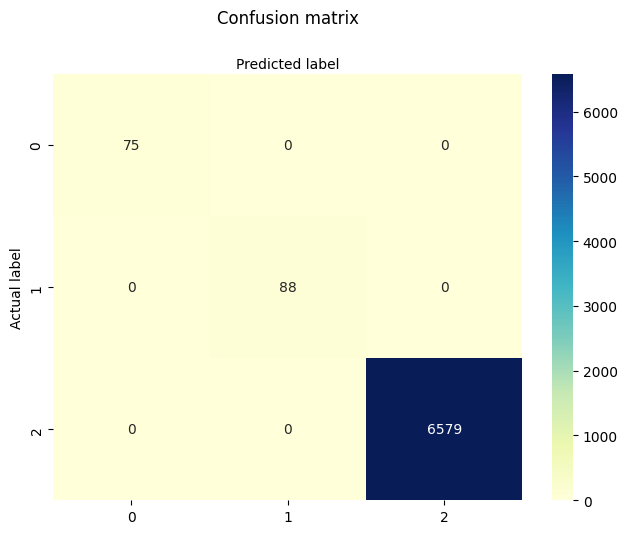

In [17]:
class_names = [0,1,2,3,4,5,6,7,8,9,10,11]

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Text(0.5,257.44,'Predicted label')

In [20]:
target_names = list(pii_number_encoding.keys())

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           2       1.00      1.00      1.00        75
           7       1.00      1.00      1.00        88
          11       1.00      1.00      1.00      6579

    accuracy                           1.00      6742
   macro avg       1.00      1.00      1.00      6742
weighted avg       1.00      1.00      1.00      6742

